# Understanding galaxy star formation rate estimates using radio luminosities

The star formation rate (SFR) of a galaxy is a fundamental property describing its current degree of activity and (together with its stellar mass) its current evolutionary state. There are, however, many different ways to estimate galaxy star formation rates, and all suffer from various limitations. Radio luminosity is potentially a unique tracer for this key property, presuming that any contribution from an active galactic nucleus (AGN) can be excluded, due to its direct link to the high-mass stellar population. In this project we will use data from EMU early science observations and the GAMA survey, in the G23 field. After excluding AGN systems through standard emission line diagnostics, we will explore a suite of common SFR estimators, and compare these against a selection of published radio SFR estimators, newly calculated for the EMU/GAMA data. We will also use the population synthesis tool, ProSpect, to provide independent SFR estimates (without relying on the radio data), as a step toward synthesising all available photometry in inferring SFRs. We will, finally, use ProSpect again to incorporate the radio measurements explicitly to derive refined SFRs, and use these directly to assess the reliabiility and robustness of any SFR estimates based on radio luminosity in isolation. A stretch goal for this project will be to link the SFRs and stellar masses for this sample to explore the “galaxy main sequence” of SFR as a function of stellar mass, and how it evolves over the redshift range spanned by the GAMA measurements.

## <span style='background :LightPink' > Load in Packages

In [1]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import cosmopy
import math
import seaborn as sns
from statistics import mean

import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9

In [2]:
import matplotlib.colors as colors
from matplotlib import path
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

### <span style='background :LightPink' > Install packages

In [3]:
pip install cosmopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## <span style='background :LightPink' > Load in Data

In [5]:
cd \Project_AHopkins\Data

G:\Project_AHopkins\Data


### <span style='background :LightPink' > EMU Data

In [6]:
EMU_G23=fits.open('G23-ASKAP-EMUES-master-cat.fits')

In [7]:
EMU_G23.info()

Filename: G23-ASKAP-EMUES-master-cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1986,)   uint8   
  1  Joined        1 BinTableHDU     69   39812R x 27C   [19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, D, K, D, D]   


In [8]:
EMU_data=Table(EMU_G23[1].data)
#EMU_data

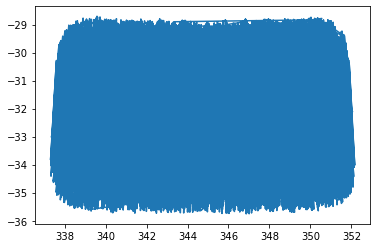

In [9]:
plt.plot(EMU_data['RA'], EMU_data['DEC'])

### <span style='background :LightPink' > GAMA

In [10]:
GFit=fits.open('GaussFitSimplev05.fits')
gkv=fits.open('gkvScienceCatv02.fits')
SMasses=fits.open('StellarMassesGKVv24.fits')

In [11]:
# GFit.info()
# gkv.info()
# SMasses.info()

In [12]:
GFit_data=Table(GFit[1].data)
#GFit_data

In [13]:
gkv_data=Table(gkv[1].data)
#gkv_data

In [14]:
SMasses_data=Table(SMasses[1].data)
#SMasses_data

In [15]:
SMasses_pd=SMasses_data.to_pandas()
gkv_pd=gkv_data.to_pandas()
GFit_pd=GFit_data.to_pandas()
EMU_pd=EMU_data.to_pandas()

#SMasses_pd

In [16]:
SMasses_pd.loc[:,"uberID"]

0         174001148708942
1         174001129809205
2         174001086008788
3         174001084207633
4         174001048108112
               ...       
370111    133000496408411
370112    176000226808518
370113    220000351709169
370114    178010820103143
370115    181010372002164
Name: uberID, Length: 370116, dtype: int64

In [17]:
GFit_pd=GFit_pd[GFit_pd.HA_FLUX >0]
#GFit_pd

In [18]:
GFit_pd=GFit_pd[GFit_pd.HB_FLUX >0]
#GFit_pd

## <span style='background :LightPink' > Cross Matching

### <span style='background :LightPink' > Join GAMA tables

##### <span style='background :LightPink' > gkv + SMasses

In [17]:
gkv_smasses = pd.merge(SMasses_pd, gkv_pd, on="uberID") 
#gkv_smasses

In [18]:
pd.set_option('display.max_columns', gkv_smasses.shape[0]+1)

##### <span style='background :LightPink' > gkv_smasses + GFit

In [19]:
# range=5/3600
# merged_data=[]
# for index1, row1 in gkv_smasses.iterrows():
#     for index2, row2 in GFit_pd.iterrows():
#         if np.absolute(row1['RAcen'] - row2['RA']) <= range:
#             merged_data.append({**row1, **row2})
# merged_df_loop = pd.DataFrame(merged_data)


In [20]:
# range=5/3600
# no=0
# merged_data=[]
# for index1, row1 in EMU_pd.iterrows():
#     for index2, row2 in gkv_smasses.iterrows():
#         dRA=np.absolute(row1['RA'] - row2['RAcen'])*np.cos(row1['DEC'])
#         ddec=np.absolute(row1['DEC'] - row2['Deccen'])
#         sep=np.sqrt((dRA**2)+(ddec**2))
#         if sep <= range:
#             merged_data.append({**row1, **row2})
#             no=no+1
#             print('sucess', no)
# merged_df_loop = pd.DataFrame(merged_data)


In [21]:
merged_df_loop

NameError: name 'merged_df_loop' is not defined

### <span style='background :LightPink' > Join GAMA and EMU tables 

In [19]:
EMU_GAMA=fits.open('G:\Project_AHopkins\Data\EMU_GAMA_DUST', ignore_missing_simple=True)
EMU_GAMA=Table(EMU_GAMA[1].data)
EMU_GAMA_pd=EMU_GAMA.to_pandas()
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
0,340700790900384,0.31191,1233.388672,6.002592,96.412086,0.767096,288.007599,11.318736,0.106793,2.141650e+11,...,-1.845745,-1.499192,2.373149e+07,4.112040e+06,3.173394e+05,9.379874e+07,3.943380e+10,1.582925e+09,5.716592e+10,340700790900384
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
3,339680671800406,0.47044,1786.454834,6.193663,98.582832,0.328227,77.153465,11.146920,0.062334,1.416731e+11,...,-1.936988,-1.618957,1.767203e+09,1.966695e+09,1.543435e+09,2.477515e+09,4.945698e+11,4.306460e+11,5.488929e+11,339680671800406
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5726,348660249910318,0.41759,1607.745728,6.090592,78.737297,0.331760,439.912079,10.340889,0.094242,2.243078e+10,...,-1.628814,-1.399607,7.806864e+08,9.053618e+08,6.931217e+08,1.130620e+09,1.117984e+11,1.002785e+11,1.292652e+11,348660249910318
5727,340670912802829,0.40617,1568.414185,6.065338,73.960327,0.027358,79.655594,10.581251,0.084757,3.873836e+10,...,-1.621519,-1.300000,9.012892e+08,1.113493e+09,8.214762e+08,1.473548e+09,2.468427e+11,2.098619e+11,2.803968e+11,340670912802829
5728,341670597809560,0.22093,893.083191,6.514818,83.343620,0.082845,130.603287,10.198410,0.117766,1.634431e+10,...,-1.455285,-1.300000,8.597193e+07,2.551703e+07,4.669147e+06,1.091130e+08,6.990946e+10,5.449755e+10,8.258319e+10,341670597809560
5729,344681077106600,0.38407,1491.401245,6.031446,67.878128,0.006544,1252.051514,9.675247,0.120922,4.914487e+09,...,-1.750961,-1.300000,5.838329e+08,5.019579e+08,2.917208e+08,6.952865e+08,6.809940e+10,4.842540e+10,7.825007e+10,344681077106600


## <span style='background :LightPink' > Data Reduction

In [20]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HA_FLUX >0]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HB_FLUX >0]
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
7,340671039311876,0.27319,1090.714600,6.091957,96.000549,0.241972,414.000000,11.036201,0.119089,1.127821e+11,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
8,339670157211832,0.25951,1039.528198,6.196827,89.685692,0.001629,18.945932,10.671826,0.033278,4.712482e+10,...,-1.404455,-1.300000,7.209989e+08,5.834123e+08,4.458350e+08,7.013334e+08,7.537197e+10,6.275906e+10,9.300512e+10,340671231211823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,350700779706966,0.29691,1178.367554,6.014777,103.949173,0.169448,67.873055,11.578385,0.060968,3.821441e+11,...,-1.367120,-1.300000,3.207524e+04,2.311706e+05,4.639701e+03,1.235227e+07,3.333751e+08,8.339254e+06,9.243494e+09,350700779706966
5721,350700869607448,0.29629,1176.082886,6.014777,96.647598,0.665532,310.387695,11.002927,0.103550,1.033753e+11,...,-1.732994,-1.300000,1.092698e+09,6.629458e+08,7.049310e+07,1.400598e+09,1.418528e+11,1.083713e+11,2.283225e+11,350700869607448
5722,350701026307521,0.13208,543.993652,6.385637,93.500618,0.530588,529.599487,9.627587,0.097031,4.352287e+09,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521
5724,350701003108055,0.20657,837.600220,6.561893,105.602364,0.457523,412.152557,10.349098,0.117715,2.316448e+10,...,-1.972705,-1.528802,3.100192e+08,2.870679e+08,1.422809e+08,4.208902e+08,4.281858e+10,3.506062e+10,6.223780e+10,350701003108055


In [21]:
#Signal to noise
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HA_FLUX/EMU_GAMA_pd.HA_FLUX_ERR) >3]
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HB_FLUX/EMU_GAMA_pd.HB_FLUX_ERR) >3]
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
7,340671039311876,0.27319,1090.714600,6.091957,96.000549,0.241972,414.000000,11.036201,0.119089,1.127821e+11,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,1314.471191,5.995922,99.549995,0.223973,109.982231,10.743343,0.074796,5.617803e+10,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,350700714905249,0.20737,840.708923,6.561893,105.187096,0.487933,221.823257,10.831931,0.134939,7.133109e+10,...,-1.898732,-1.300000,5.320658e+07,1.734357e+08,4.220364e+07,3.004535e+08,6.076179e+10,3.149417e+10,1.273855e+11,350700714905249
5707,350701057705467,0.06332,262.953766,6.019169,104.439766,0.902125,352.651825,9.861770,0.103092,7.477530e+09,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,344.976959,6.123384,106.104965,0.724637,307.583527,10.505146,0.127696,3.340214e+10,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,543.993652,6.385637,93.500618,0.530588,529.599487,9.627587,0.097031,4.352287e+09,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


In [22]:
EMU_GAMA=Table.from_pandas(EMU_GAMA_pd)
#EMU_GAMA.write('EMU_GAMA_reduced.fits')

## <span style='background :LightPink' > BPT Diagnostics

add kewley and kauffmann lines 

kauffmann log(OIII/HB) = 1.3 + 0.61/(log(NII/HA)-0.05)

kewely log(OIII/HB) = (0.61/(log(NII/HA) -0.47))+ 1.19 

In [23]:
HB=EMU_GAMA_pd['HB_FLUX']
HA=EMU_GAMA_pd['HA_FLUX']
NII=EMU_GAMA_pd['NIIR_FLUX']
OIII=EMU_GAMA_pd['OIIIR_FLUX']

x=np.log10(NII/HA)
y=np.log10(OIII/HB)

D:\anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
x=np.array(x)
x[:]

array([-0.3704116 , -0.3675569 , -0.00425612, ..., -0.42903653,
       -0.71284914, -0.72704536], dtype=float32)

In [25]:
EMU_GAMA_pd.insert(2, "log(NII/Ha)", x[:])
EMU_GAMA_pd.insert(3, "log(OIII/HB)", y[:])

Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

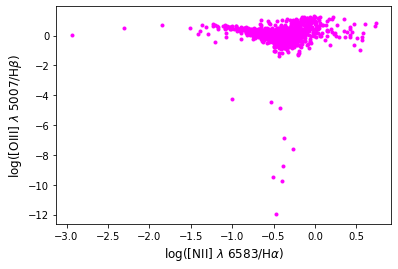

In [26]:
Nsize = 12
fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [27]:
x1=np.log10(np.arange(-50, 1, 0.01))
x2=np.log10(np.arange(-50, 2.5, 0.01))
y1=1.3 + 0.61/(x1-0.05) #kauffmann
y2=(0.61/(x2 -0.47))+1.19  #kewely

C:\Users\Jayde\AppData\Local\Temp\ipykernel_13556\3782894524.py:1: RuntimeWarning: invalid value encountered in log10
  x1=np.log10(np.arange(-50, 1, 0.01))
C:\Users\Jayde\AppData\Local\Temp\ipykernel_13556\3782894524.py:2: RuntimeWarning: invalid value encountered in log10
  x2=np.log10(np.arange(-50, 2.5, 0.01))


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

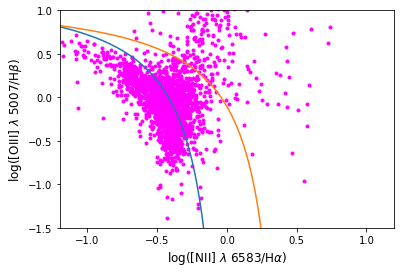

In [28]:

fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
plt.plot(x1,y1)
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [29]:

H, xedges, yedges = np.histogram2d(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'],range=[[-1.3,1.3],[-1.5,1.1]], bins=60)
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
if astro_smooth:
    kernel = Gaussian2DKernel(x_stddev=1)
    H=convolve(H,kernel)


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

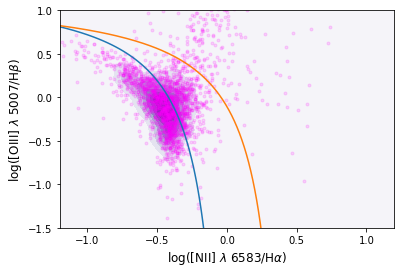

In [30]:
fig, ax = plt.subplots()
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples')
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta', alpha=0.15)
plt.plot(x1,y1, label='Kaufmann')
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

## 

### <span style='background :LightPink' > Creating Sample1

In [31]:
sample1=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']<1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]
#sample1

In [32]:
sample1=sample1[sample1['log(NII/Ha)']<0]

In [33]:
#sample1
#plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'])

In [34]:
sample1['log(NII/Ha)']

1      -0.370412
2      -0.367557
7      -0.333282
11     -0.454101
13     -0.740513
          ...   
5701   -0.401403
5707   -0.390901
5716   -0.429037
5722   -0.712849
5724   -0.727045
Name: log(NII/Ha), Length: 1255, dtype: float32

In [35]:
#from astropy.table import Table
t=Table.from_pandas(sample1)

In [36]:
#t.write('G:\\Project_AHopkins\Data\sample1.fits')

### <span style='background :LightPink' > Creating Sample2

In [37]:
sample2=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']>1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]

In [38]:
#(0.61/(x -0.47))+1.19
sample2=sample2[sample2['log(OIII/HB)']<1.19 + 0.61/(sample2['log(NII/Ha)']-0.47)]
#sample2

In [39]:
#plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'])

In [40]:
samp2=Table.from_pandas(sample2)
#samp2.write('G:\\Project_AHopkins\Data\sample2.fits', overwrite=True)

### <span style='background :LightPink' > Creating Sample3

In [41]:
mask1= (EMU_GAMA_pd['log(OIII/HB)']>1.19 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.47))
mask2= (EMU_GAMA_pd['log(NII/Ha)']>0.1)


In [42]:
sample3=EMU_GAMA_pd[mask1 | mask2]
#sample3

In [43]:
#plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'])

In [44]:
samp3=Table.from_pandas(sample3)
samp3.write('G:\\Project_AHopkins\Data\sample3.fits', overwrite=True)

### <span style='background :LightPink' > Return to BPT

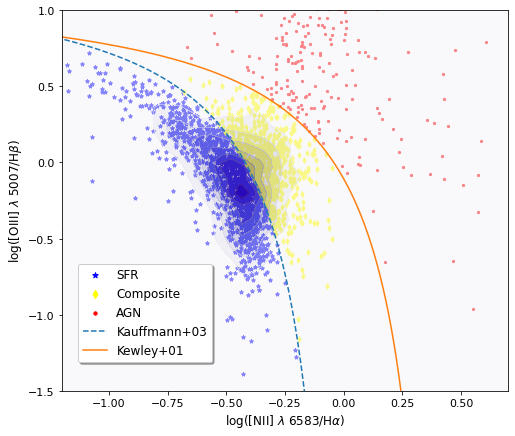

In [45]:
fig, ax = plt.subplots(figsize=(8,7))

plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'], color='blue', marker='*', sizes=[15], label='SFR')
plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'], color='yellow',marker='d', sizes=[15], label='Composite')
plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'], color='red', marker='.',sizes=[20], label='AGN')


#plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='black')
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples',alpha=0.55)

plt.plot(x1,y1, linestyle='dashed', label='Kauffmann+03')
plt.plot(x2, y2, label='Kewley+01' )
ax.set_xlim(-1.2,0.7)
ax.set_ylim(-1.5,1)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
ax.legend(loc='upper right', bbox_to_anchor=(0.35, 0.35), fontsize=12, markerscale=1.5, shadow=True)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=12)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=12)
#plt.scatter(kaufmann_points[0],kaufmann_points[1], marker="*", alpha=0.3)
plt.savefig('E:\\BPT.png')

## <span style='background :LightPink' > Radio Flux to SFR

## <span style='background :LightPink' >  Calculate Distances

In [46]:
z_1=np.array(sample1['Z_1'])

In [47]:
print(cosmopy.api('z', z_1[0]))

{'z': '0.0759', 'a': '0.9294', 'dc': '322.9004 Mpc', 'dl': '347.4214 Mpc', 'da': '300.1100 Mpc', 'arc': '1454.9745 pc', 'tl': '1.0153 Gyr', 'ta': '12.7374 Gyr', 'dm': '37.7043'}


In [48]:
sample1['Z_1']

1       0.07594
2       0.07579
7       0.27319
11      0.33424
13      0.17895
         ...   
5701    0.13444
5707    0.06332
5716    0.08315
5722    0.13208
5724    0.20657
Name: Z_1, Length: 1255, dtype: float32

In [49]:
sample1=sample1[sample1['HA_FLUX']<100000]
sample1=sample1[sample1['HA_EW']>0]

In [50]:
#pd.set_option('display.max_rows', None)
pd.reset_option('all')

D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [51]:
sample1['HA_FLUX']

1        1356.179321
2         542.241394
7        1067.201904
11        265.482544
13        496.988495
            ...     
5701    22865.724609
5707      962.744385
5716    32747.402344
5722      210.414764
5724    13437.446289
Name: HA_FLUX, Length: 1249, dtype: float32

In [52]:
#comoving method
DistLum=(1+sample1['Z_1'])*(sample1['comovingdist'])
DistLum

1        339.385101
2        338.671387
7       1388.686890
11      1753.819946
13       860.937561
           ...     
5701     627.897217
5707     279.604004
5716     373.661804
5722     615.844299
5724    1010.623352
Length: 1249, dtype: float32

In [53]:
#Mpc to m
DistLum=DistLum*3.08567758128E+22
DistLum

1       1.047233e+25
2       1.045031e+25
7       4.285040e+25
11      5.411723e+25
13      2.656576e+25
            ...     
5701    1.937488e+25
5707    8.627678e+24
5716    1.153000e+25
5722    1.900297e+25
5724    3.118458e+25
Length: 1249, dtype: float32

In [54]:
sample1.insert(2, "Luminosity_Distance", DistLum[:])

In [55]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.luminosity_distance(0.07594)

<Quantity 347.49888225 Mpc>

## <span style='background :LightPink' > Radio Luminosity


<div>
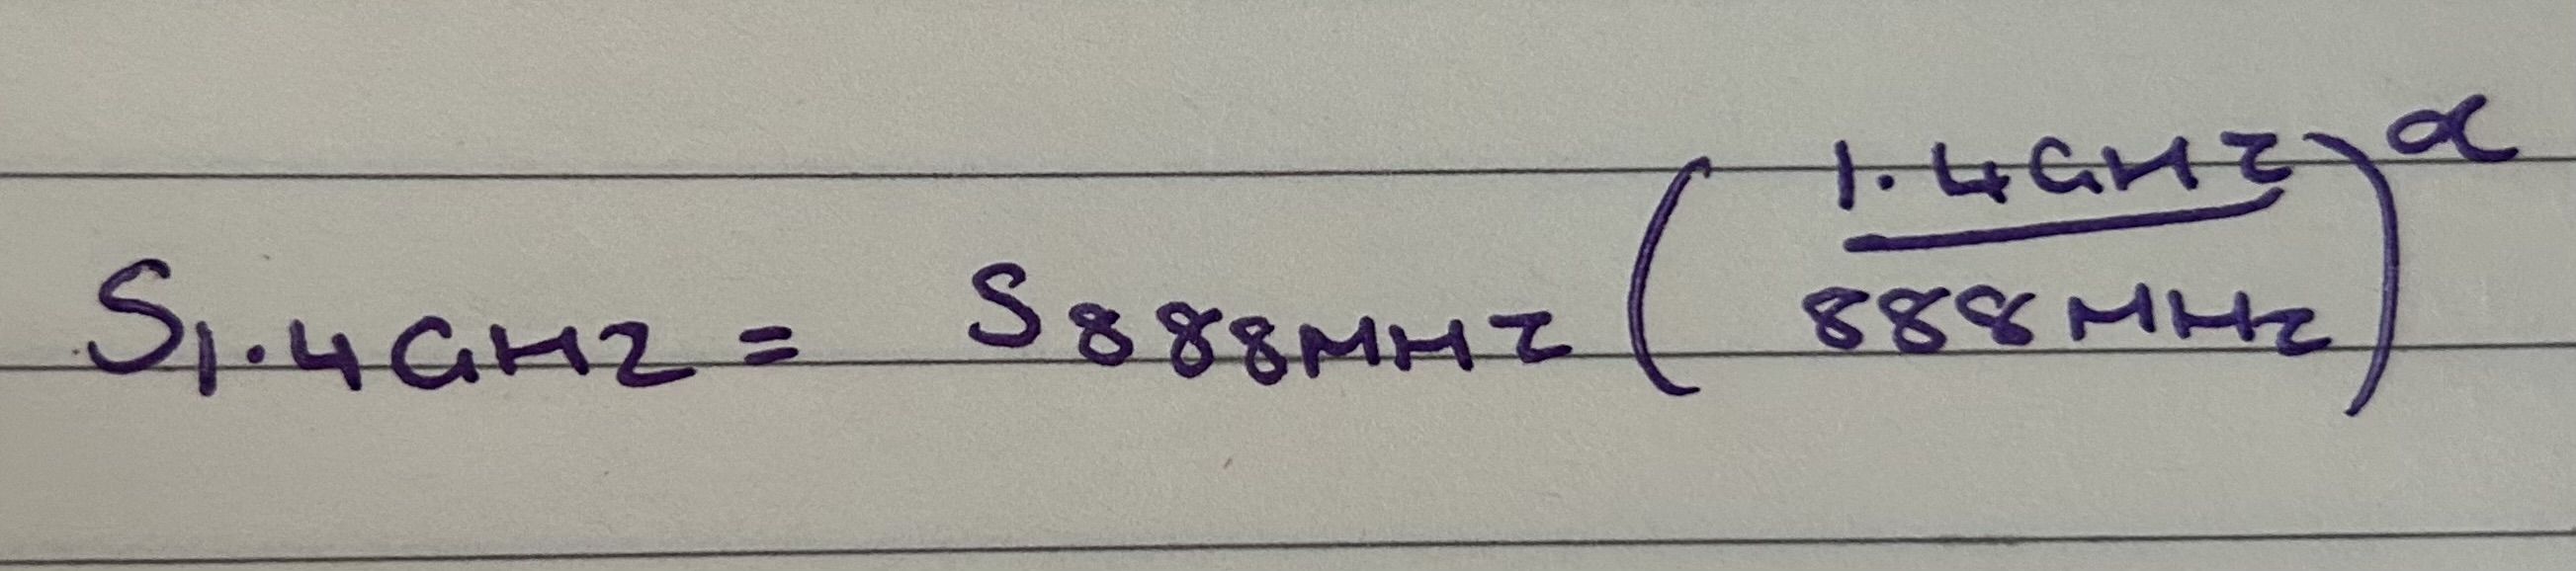
</div>



<div>
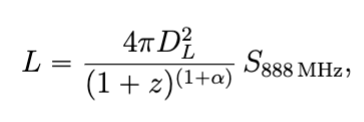
</div>

In [56]:
Dl=np.array(sample1['Luminosity_Distance'])


In [57]:
i=0
alpha=-0.7
flux888=np.array(sample1['Total_flux']*(10**(-26)))  #Janksy flux to W/Hz
flux14=np.array((sample1['Total_flux']*((1400/888)**alpha))*(10**(-26))) # 888 to 1.4 + Janksy flux to W/Hz
Dl2=[]
RadioLum14=[]
RadioLum888=[]
while i<1249:
 Dl2.append(float(Dl[i]**2))
 RadioLum888.append(((4*math.pi*Dl2[i])*flux888[i])/((1+z_1[i])**(1+alpha)))
 RadioLum14.append(((4*math.pi*Dl2[i])*flux14[i])/((1+z_1[i])**(1+alpha)))
 i=i+1

In [58]:
RadioLum14

[5.456070137866776e+21,
 1.924564722835454e+21,
 6.971197291517459e+22,
 5.0014017551972354e+22,
 1.8247420862272973e+22,
 2.686722692466786e+22,
 1.3226606152160167e+22,
 1.5295372802176387e+22,
 4.9383221755260376e+22,
 8.212661733586207e+21,
 7.2345753412689e+21,
 5.338677703878192e+22,
 4.514174189329986e+22,
 4.785897881330757e+21,
 3.5246965865300636e+22,
 4.2589279235068595e+21,
 1.0416012540691601e+22,
 8.494225393934871e+22,
 4.787403285006543e+22,
 8.939792437113683e+21,
 1.01156573475289e+23,
 5.502932385215785e+21,
 1.5724860695384796e+22,
 1.0198670358691967e+22,
 2.23302408409928e+22,
 1.2094114571827355e+22,
 2.2183419614055865e+21,
 9.598181099155726e+21,
 6.58547716904789e+22,
 2.448157786406573e+22,
 2.0065764624349916e+22,
 9.5425483591278e+22,
 1.3712976489297977e+22,
 3.585392006587334e+20,
 2.0967376521003184e+22,
 2.904173478627089e+22,
 4.1291784509183125e+22,
 5.933154047235909e+21,
 7.905263776249835e+22,
 1.6377067995523789e+22,
 6.572295698539116e+22,
 3.248

In [59]:
sample1.insert(2, "Radio_luminosity_14", RadioLum14[:])
sample1.insert(3, "Radio_luminosity_888", RadioLum888[:])


In [60]:
sample1=sample1[sample1['Radio_luminosity_14']<9e24]

In [61]:
sample1

,uberID_1,Z_1,Radio_luminosity_14,Radio_luminosity_888,Luminosity_Distance,log(NII/Ha),log(OIII/HB),comovingdist,nefffilt,snratio,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,5.456070e+21,7.503787e+21,1.047233e+25,-0.370412,-0.220083,315.431244,6.085568,109.384338,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,1.924565e+21,2.646873e+21,1.045031e+25,-0.367557,-0.580876,314.811798,6.085568,102.400002,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
7,340671039311876,0.27319,6.971197e+22,9.587556e+22,4.285040e+25,-0.333282,-0.733671,1090.714600,6.091957,96.000549,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,5.001402e+22,6.878477e+22,5.411723e+25,-0.454101,-0.695246,1314.471191,5.995922,99.549995,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
13,339680581501726,0.17895,1.824742e+22,2.509586e+22,2.656576e+25,-0.740513,0.275441,730.257935,6.517847,104.533318,...,-1.807700,-1.520700,1.344611e+08,1.780425e+08,1.103541e+08,2.428474e+08,2.653973e+10,2.352532e+10,3.274499e+10,339670402412343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,350701040104571,0.13444,2.174635e+22,2.990797e+22,1.937488e+25,-0.401403,-0.069131,553.486511,6.398734,111.359711,...,-1.637408,-1.386055,2.241911e+08,2.136106e+08,1.604303e+08,2.606047e+08,4.417676e+10,3.571403e+10,5.030358e+10,350701040104571
5707,350701057705467,0.06332,1.737352e+21,2.389398e+21,8.627678e+24,-0.390901,-0.841144,262.953766,6.019169,104.439766,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,8.562661e+21,1.177631e+22,1.153000e+25,-0.429037,-0.349897,344.976959,6.123384,106.104965,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,1.279551e+23,1.759779e+23,1.900297e+25,-0.712849,0.124575,543.993652,6.385637,93.500618,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


## <span style='background :LightPink' >  Radio Lum to SFR

## <span style='background :LightPink' > Bell 2003


<div>
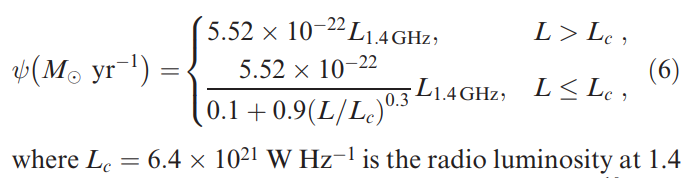
</div>

Is L our L_1.4?

In [62]:
i=0
Bell_SFR=[]
while i<1248:
    if RadioLum14[i]>(6.4e21):
        Bell_SFR.append((5.5e-22)*RadioLum14[i])
    else: 
        Bell_SFR.append(((5.5e-22)*RadioLum14[i])/(0.1+0.9*((RadioLum14[i]/6.4e21)**0.3)))
    i=i+1

In [63]:
Bell_SFR

[3.1326240718818688,
 1.4547819874683825,
 38.34158510334603,
 27.507709653584797,
 10.036081474250135,
 14.776974808567324,
 7.274633383688092,
 8.412455041197013,
 27.160771965393206,
 4.5169639534724135,
 3.979016437697895,
 29.362727371330056,
 24.827958041314922,
 2.8461155426289433,
 19.38583122591535,
 2.6128775732156244,
 5.728806897380381,
 46.71823966664179,
 26.330718067535987,
 4.916885840412526,
 55.63611541140895,
 3.1522774131448306,
 8.648673382461638,
 5.609268697280582,
 12.281632462546039,
 6.651763014505046,
 1.6161535014056267,
 5.278999604535649,
 36.220124429763395,
 13.464867825236153,
 11.036170543392455,
 52.4840159752029,
 7.542137069113887,
 0.41160111824380113,
 11.532057086551752,
 15.972954132448988,
 22.71048148005072,
 3.330578210357519,
 43.478950769374094,
 9.007387397538084,
 36.147626341965136,
 17.86766559787203,
 27.713276959127487,
 32.65335398909242,
 16.13477309059533,
 2.3751857668024545,
 5.5820354365852545,
 8.121869687258934,
 18.9808572265

In [64]:
sample1.insert(2, "Bell_SFR", Bell_SFR[:])

## <span style='background :LightPink' > Condon 1992


<div>
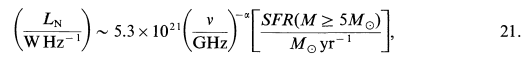
</div>


$$ SFR(M\ge 5M_☉) = \frac{5.3\times 10^{-21}  L_{1.4GHz}}{(1.4)^{0.7}} $$

In [65]:
#below A 2001 condon with calibration
Condon_SFR=(sample1['Radio_luminosity_14']/(8.4e20))

In [66]:
sample1.insert(2, "Condon_SFR", Condon_SFR[:])
Condon_SFR

1         6.495322
2         2.291148
7        82.990444
11       59.540497
13       21.723120
           ...    
5701     25.888517
5707      2.068276
5716     10.193644
5722    152.327500
5724     25.448528
Name: Radio_luminosity_14, Length: 1248, dtype: float64

## <span style='background :LightPink' > Hα Flux to SFR

### <span style='background :LightPink' > Calculate L$_{H\alpha}$

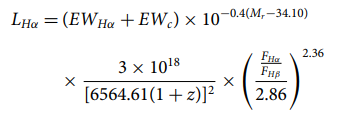


In [67]:
Ha=sample1['HA_FLUX']
Hb=sample1['HB_FLUX']

In [68]:
EW_Ha=sample1['HA_EW']
EW_c= 1.3  #˚A from Hopkins(2003)  #EWc is the equivalent width correction for stellar absorption
Mr=sample1['absmag_r']
z=sample1['Z_1']

In [69]:
Lum_HA=(EW_Ha + EW_c)*(10**(-0.4*(Mr-34.10)))*((3*(10**18))/(6564.61*(1+z))**2)*(((Ha/Hb)/2.86)**2.36)

In [70]:
Lum_HA=np.array(Lum_HA)
Lum_HA

array([1.36739242e+35, 1.02955287e+34, 7.78585724e+35, ...,
       1.96508788e+36, 2.69510105e+34, 2.69314892e+35])

In [71]:
sample1.insert(2, "HA_Luminosity", Lum_HA[:])

## <span style='background :LightPink' > Ahmed 2024

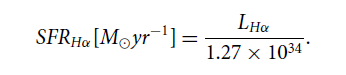
From Tanias^^

In [72]:
SFR_HA_Tan=1.27*(10**-34)*Lum_HA
SFR_HA_Tan

array([ 17.36588368,   1.30753215,  98.88038692, ..., 249.56616035,
         3.42277833,  34.20299129])

In [73]:
sample1.insert(2, "Ha_SFR", SFR_HA_Tan[:])

## <span style='background :LightPink' > Radio + Ha to SFR 

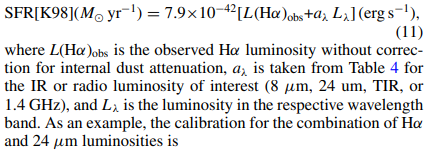

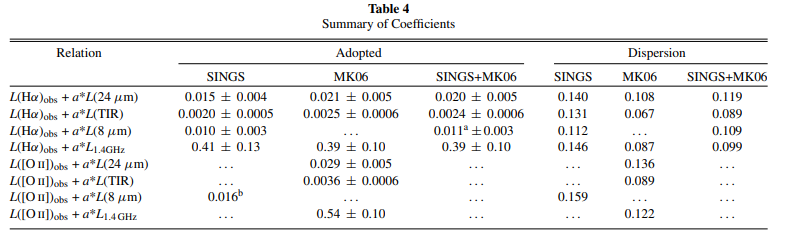

In [74]:
K98_SFR=((7.9e-42)*((Lum_HA*(1e7))+(0.39*sample1['Radio_luminosity_14']*(1e7))))

In [75]:
K98_SFR

1        10.802400
2         0.813347
7        61.508272
11       26.349708
13       11.070209
           ...    
5701     22.990443
5707      3.176851
5716    155.241942
5722      2.129130
5724     21.275876
Name: Radio_luminosity_14, Length: 1248, dtype: float64

In [76]:
sample1.insert(2, "K98_SFR", K98_SFR[:])


## <span style='background :LightPink' > Ha + Dust Mass SFR (Tanias) </span>

In [77]:
Dust_Mass=sample1['DustMass_bestfit']
Dust_Mass

1       9.836123e+07
2       9.108934e+06
7       2.881511e+08
11      3.820698e+08
13      1.344611e+08
            ...     
5701    2.241911e+08
5707    5.315158e+07
5716    6.286991e+07
5722    5.518692e+06
5724    3.100192e+08
Name: DustMass_bestfit, Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate $\tau$

$\tau^l_B = 2.303\log(\frac{\text{H}\alpha}{\text{H}\beta}) - 1.0508$

In [78]:
tau=2.303*np.log10(Ha/Hb)-1.0508
tau

1       1.028563
2       0.227932
7       1.017851
11      0.874798
13      0.580236
          ...   
5701    0.926170
5707    0.845029
5716    1.838001
5722    0.563942
5724    0.899251
Length: 1248, dtype: float32

### <span style='background :LightPink' > Calculate H$_{dust}$

$H_{\rm dust} = \frac{M_d}{10^{\tau^l_B}}$

In [79]:
H_dust=Dust_Mass/(10**tau)
H_dust

1       9.210020e+06
2       5.389341e+06
7       2.765469e+07
11      5.097351e+07
13      3.534764e+07
            ...     
5701    2.657349e+07
5707    7.594290e+06
5716    9.129394e+05
5722    1.506241e+06
5724    3.909647e+07
Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate L$_{H\alpha,improved}$

In [80]:
L_Ha_impr=(10**((np.log10(H_dust)-22.564)/(1.165)))*(Lum_HA)
L_Ha_impr

1       5.566201e+21
2       2.645760e+20
7       8.144238e+22
11      5.897321e+22
13      1.809538e+22
            ...     
5701    2.941692e+22
5707    1.387161e+21
5716    1.100021e+22
5722    2.318720e+20
5724    3.792070e+22
Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate SFR

In [81]:
Dust_SFR=(7.9e-35)*(Lum_HA+(0.39e13))
Dust_SFR

array([ 10.80240009,   0.81334677,  61.50827218, ..., 155.24194227,
         2.12912983,  21.27587647])

In [82]:
sample1.insert(2, "Dust_SFR", Dust_SFR[:])

### <span style='background :LightPink' >Final Cuts

In [83]:
sample1=sample1[sample1['HA_Luminosity']>2e-13]
sample1

,uberID_1,Z_1,Dust_SFR,K98_SFR,Ha_SFR,HA_Luminosity,Condon_SFR,Bell_SFR,Radio_luminosity_14,Radio_luminosity_888,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,10.802400,10.802400,17.365884,1.367392e+35,6.495322,3.132624,5.456070e+21,7.503787e+21,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,0.813347,0.813347,1.307532,1.029553e+34,2.291148,1.454782,1.924565e+21,2.646873e+21,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
7,340671039311876,0.27319,61.508272,61.508272,98.880387,7.785857e+35,82.990444,38.341585,6.971197e+22,9.587556e+22,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,26.349708,26.349708,42.359657,3.335406e+35,59.540497,27.507710,5.001402e+22,6.878477e+22,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
13,339680581501726,0.17895,11.070209,11.070209,17.796412,1.401292e+35,21.723120,10.036081,1.824742e+22,2.509586e+22,...,-1.807700,-1.520700,1.344611e+08,1.780425e+08,1.103541e+08,2.428474e+08,2.653973e+10,2.352532e+10,3.274499e+10,339670402412343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,350701040104571,0.13444,22.990443,22.990443,36.959320,2.910183e+35,25.888517,17.388235,2.174635e+22,2.990797e+22,...,-1.637408,-1.386055,2.241911e+08,2.136106e+08,1.604303e+08,2.606047e+08,4.417676e+10,3.571403e+10,5.030358e+10,350701040104571
5707,350701057705467,0.06332,3.176851,3.176851,5.107089,4.021330e+34,2.068276,11.960495,1.737352e+21,2.389398e+21,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,155.241942,155.241942,249.566160,1.965088e+36,10.193644,1.348434,8.562661e+21,1.177631e+22,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,2.129130,2.129130,3.422778,2.695101e+34,152.327500,4.709463,1.279551e+23,1.759779e+23,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


In [90]:
t=Table.from_pandas(sample1)
t.write('G:\\Project_AHopkins\Data\sample1_final.fits', overwrite=True)

## <span style='background :LightPink' >  Import Prospect Data

In [96]:
EMU_GAMA_DUST_PROSPECT=fits.open('G:\Project_AHopkins\Data\Sample1XProspect\EMU_GAMA_DUST_PROSPECT', ignore_missing_simple=True)
EMU_GAMA_DUST_PROSPECT=Table(EMU_GAMA_DUST_PROSPECT[1].data)
EMU_GAMA_DUST_PROSPECT_pd=EMU_GAMA_DUST_PROSPECT.to_pandas()
EMU_GAMA_DUST_PROSPECT_pd


,uberID_1,Z_1,Dust_SFR,K98_SFR,Ha_SFR,HA_Luminosity,Condon_SFR,Bell_SFR,Radio_luminosity_14,Radio_luminosity_888,...,uberID,filenames,SPECID_SED,SFRpeak,SFRmedian,dustmasstot,masstot,z_SED,GroupID,GroupSize
0,339680398800078,0.07594,10.802400,10.802400,17.365884,1.367392e+35,6.495322,3.132624,5.456070e+21,7.503787e+21,...,339680398800078,G23_Y7_042_233_EMU_data,G23_Y7_042_233,8.79717909647571,3.74614276864125,433201.375341709,77970260222.0387,0.07594,1,2
1,339680398800078,0.07594,10.802400,10.802400,17.365884,1.367392e+35,6.495322,3.132624,5.456070e+21,7.503787e+21,...,339680398800078,G23_Y7_042_233_NoEMU_data,G23_Y7_042_233,9.32296602587639,3.03791344768464,344596.689913061,81557563035.1826,0.07594,1,2
2,339670202310631,0.07579,0.813347,0.813347,1.307532,1.029553e+34,2.291148,1.454782,1.924565e+21,2.646873e+21,...,339680381000017,G23_Y7_022_153_EMU_data,G23_Y7_022_153,2.29012472248803,1.16551324625226,143659.182601959,11538257870.5085,0.07579,2,2
3,339670202310631,0.07579,0.813347,0.813347,1.307532,1.029553e+34,2.291148,1.454782,1.924565e+21,2.646873e+21,...,339680381000017,G23_Y7_022_153_NoEMU_data,G23_Y7_022_153,2.19263359465455,1.21433097087935,146582.926502461,11724827892.7218,0.07579,2,2
4,340671039311876,0.27319,61.508272,61.508272,98.880387,7.785857e+35,82.990444,38.341585,6.971197e+22,9.587556e+22,...,340671039311876,G23_Y5_077_079_EMU_data,G23_Y5_077_079,384.236374072981,0.520275496728214,699574931.57982,298683378544.806,0.27319,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,350700902306866,0.08315,155.241942,155.241942,249.566160,1.965088e+36,10.193644,1.348434,8.562661e+21,1.177631e+22,...,350700902306866,2dF125301_NoEMU_data,2dF125301,14.3273732977464,5.86075376448039,808950.523242946,68435954898.335,0.08315,1245,2
2490,350701026307521,0.13208,2.129130,2.129130,3.422778,2.695101e+34,152.327500,4.709463,1.279551e+23,1.759779e+23,...,350701026307521,G23_Y7_033_302_EMU_data,G23_Y7_033_302,1.60524910827014,1.56593792028993,390145.973987535,11029263095.185,0.13208,1246,2
2491,350701026307521,0.13208,2.129130,2.129130,3.422778,2.695101e+34,152.327500,4.709463,1.279551e+23,1.759779e+23,...,350701026307521,G23_Y7_033_302_NoEMU_data,G23_Y7_033_302,1.44022286019162,1.39437157461513,4050520.12678855,11152202327.355,0.13208,1246,2
2492,350701003108055,0.20657,21.275876,21.275876,34.202991,2.693149e+35,25.448528,70.375305,2.137676e+22,2.939967e+22,...,350701003108055,2dF125329_EMU_data,2dF125329,19.8669437461955,13.2448695560799,89830494.5172099,22570644876.6351,0.20657,1247,2


In [105]:
evens=np.arange(0,2494,2)
odds=np.arange(1,2494,2)

In [113]:
Prospect_Radio=EMU_GAMA_DUST_PROSPECT_pd.iloc[::2]
Prospect_Radio_SFR=Prospect_Radio['SFRpeak']
Prospect_Radio_SFR

Prospect_NoRadio=EMU_GAMA_DUST_PROSPECT_pd.iloc[1::2]
Prospect_NoRadio_SFR=Prospect_NoRadio['SFRpeak']
Prospect_NoRadio_SFR


1       9.32296602587639
3       2.19263359465455
5       977.249868051815
7       30.4062978753416
9       4.54382213372668
              ...       
2485    10.4979850243744
2487    1.65540836636231
2489    14.3273732977464
2491    1.44022286019162
2493    18.9856422065077
Name: SFRpeak, Length: 1247, dtype: object

## <span style='background :LightPink' > Corner Plot

Goal:
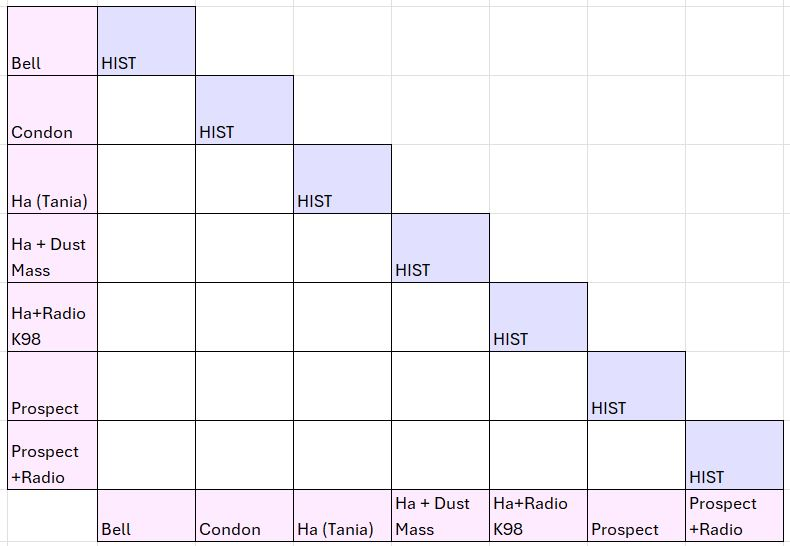

In [73]:
SFR_all= sample1[['Bell_SFR', 'Condon_SFR', 'Ha_SFR', 'K98_SFR', 'Dust_SFR']].copy()

In [74]:
SFR_all

,Bell_SFR,Condon_SFR,Ha_SFR,K98_SFR,Dust_SFR
1,3.132624,6.495322,17.365884,10.802400,10.802400
2,1.454782,2.291148,1.307532,0.813347,0.813347
7,38.341585,82.990444,98.880387,61.508272,61.508272
11,27.507710,59.540497,42.359657,26.349708,26.349708
13,10.036081,21.723120,17.796412,11.070209,11.070209
...,...,...,...,...,...
5701,17.388235,25.888517,36.959320,22.990443,22.990443
5707,11.960495,2.068276,5.107089,3.176851,3.176851
5716,1.348434,10.193644,249.566160,155.241942,155.241942
5722,4.709463,152.327500,3.422778,2.129130,2.129130


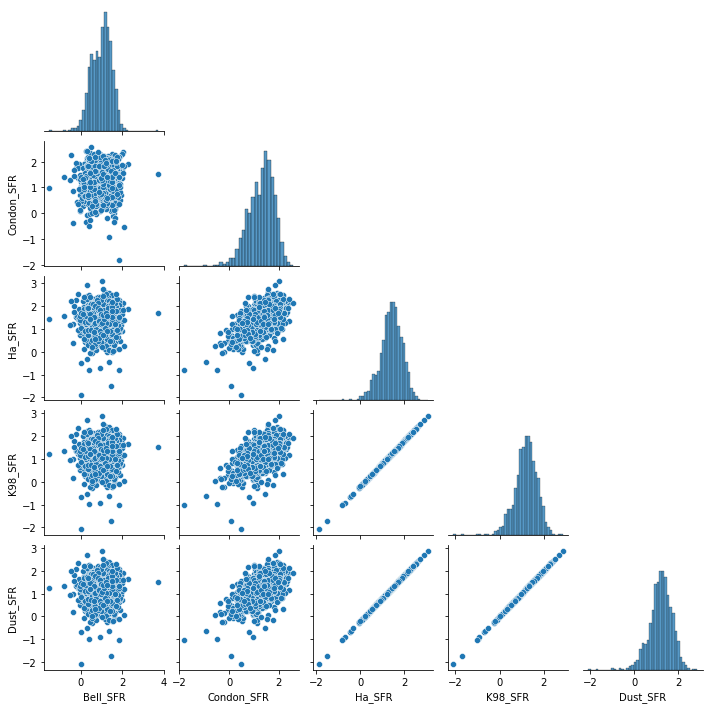

In [75]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
#sns_plot.savefig('Corner.png')

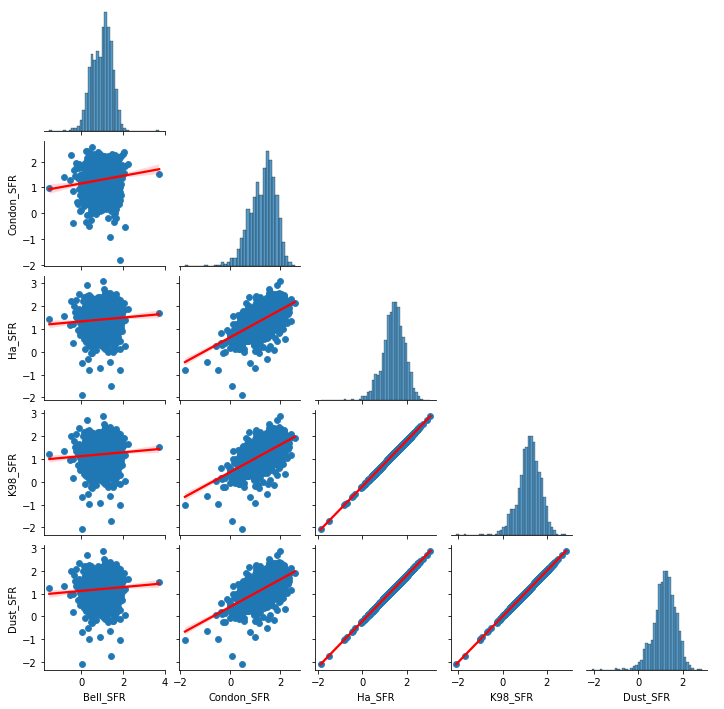

In [76]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.map_lower(sns.regplot, line_kws=dict(color="r"))
sns_plot.add_legend()

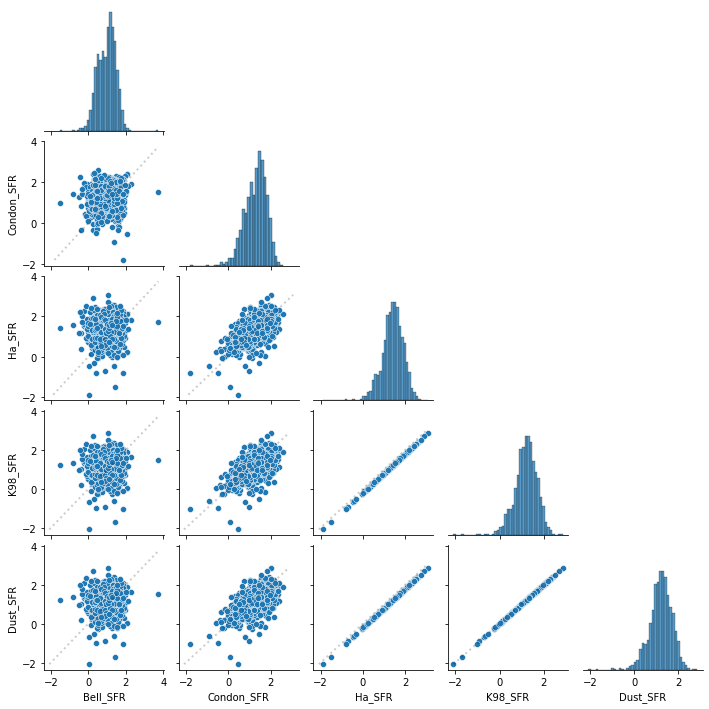

In [77]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='dotted', linewidth=2.0, alpha=0.2)


sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.map_lower(plot_unity)


In [225]:
#sns_plot.savefig('Cornerlines.png')

## <span style='background :LightPink' > LOBF Gradient and Stats

In [79]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b


In [80]:
mbs=[]
mbs.append(['BellvsCondon',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])])
mbs.append(['BellvsHa',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['BellvsK98',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['K98_SFR'])])
mbs.append(['BellvsDust',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])])

mbs.append(['CondonvsHa',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['CondonvsK98',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['K98_SFR'])])
mbs.append(['CondonvsDust',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])])

mbs.append(['HavsK98',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['K98_SFR'])])
mbs.append(['HavsDust',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])])

mbs.append(['K98vsDust',best_fit_slope_and_intercept(SFR_all['K98_SFR'],SFR_all['Dust_SFR'])])


In [81]:
mbs

[['BellvsCondon', (0.0035655919171689583, 34.598328278415366)],
 ['BellvsHa', (0.0022717902749258296, 46.55913295529822)],
 ['BellvsK98', (0.0014131608796783604, 28.961980342273016)],
 ['BellvsDust', (0.0014131608796782707, 28.96198034227212)],
 ['CondonvsHa', (0.617551851301532, 25.19430119813298)],
 ['CondonvsK98', (0.384146427187593, 15.672045627185085)],
 ['CondonvsDust', (0.38414642718756703, 15.67204562718509)],
 ['HavsK98', (0.6220472440944934, 6.572520305780927e-13)],
 ['HavsDust', (0.6220472440944882, 3.552713678800501e-15)],
 ['K98vsDust', (0.9999999999999916, -6.501466032204917e-13)]]

### <span style='background :LightPink' > Scatter


In [83]:
def point_to_line_distance(x0, y0, slope, intercept):
    # Calculate the perpendicular distance
    distance = abs(slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)
    return distance

In [84]:
mbs[1][1]

(0.0022717902749258296, 46.55913295529822)

In [85]:
dist = {'BellvsCondon': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], mbs[0][1][0], mbs[0][1][1]),
        'BellvsHa': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'], mbs[1][1][0], mbs[1][1][1]),
        'BellvsK98': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['K98_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'BellvsDust': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'CondonvsHa': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'], mbs[3][1][0], mbs[3][1][1]),
        'CondonvsK98': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['K98_SFR'], mbs[4][1][0], mbs[4][1][1]),
        'CondonvsDust': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'HavsK98':point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['K98_SFR'], mbs[5][1][0], mbs[5][1][1]),
        'HavsDust': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'K98vsDust': point_to_line_distance(SFR_all['K98_SFR'],SFR_all['Dust_SFR'], mbs[2][1][0], mbs[2][1][1])}
dist_df=pd.DataFrame(dist)
#point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], mbs[0][1][0], mbs[0][1][1])
dist_df

,BellvsCondon,BellvsHa,BellvsK98,BellvsDust,CondonvsHa,CondonvsK98,CondonvsDust,HavsK98,HavsDust,K98vsDust
1,28.113998,29.200291,18.163989,18.163989,11.605264,15.657986,18.168741,10.773142,18.184103,18.174828
2,32.312162,45.254789,28.150661,28.150661,27.657658,21.947998,28.151843,14.339358,28.150453,28.149755
7,48.255098,52.234015,32.492077,32.492077,69.801058,12.708852,32.428981,7.329481,32.406526,32.459338
11,24.843930,4.261957,2.651143,2.651143,13.313523,30.301557,2.696410,5.222561,2.672131,2.649506
13,12.910911,28.785447,17.905936,17.905936,11.196256,23.431332,17.922452,10.677531,17.916903,17.907398
...,...,...,...,...,...,...,...,...,...,...
5701,8.771755,9.639290,5.996103,5.996103,7.960747,15.477831,6.008116,6.421860,6.023760,6.004020
5707,32.572491,41.479109,25.802006,25.802006,23.857791,19.819944,25.788027,13.495557,25.792321,25.789593
5716,24.409338,203.003440,126.277930,126.277930,220.589554,105.292893,126.265431,40.793561,125.927159,126.060454
5722,117.711631,43.146942,26.839479,26.839479,25.754440,99.662721,27.048087,13.869607,26.837661,26.835833


In [88]:
mean_dists=(['BellvsCondon',np.mean(dist_df['BellvsCondon'])],
        ['BellvsHa', np.mean(dist_df['BellvsHa'])],
        ['BellvsK98', np.mean(dist_df['BellvsK98'])],
        ['BellvsDust', np.mean(dist_df['BellvsDust'])],
        ['CondonvsHa', np.mean(dist_df['CondonvsHa'])],
        ['CondonvsK98',np.mean(dist_df['CondonvsK98'])],
        ['CondonvsDust', np.mean(dist_df['CondonvsDust'])],
        ['HavsK98', np.mean(dist_df['HavsK98'])],
        ['HavsDust', np.mean(dist_df['HavsDust'])],
        ['K98vsDust', np.mean(dist_df['K98vsDust'])])

In [89]:
mean_dists

(['BellvsCondon', 26.055631653507703],
 ['BellvsHa', 37.46379513515774],
 ['BellvsK98', 23.304287384453264],
 ['BellvsDust', 23.30428738445327],
 ['CondonvsHa', 33.379178509895034],
 ['CondonvsK98', 25.26431128989227],
 ['CondonvsDust', 23.294962293398115],
 ['HavsK98', 10.441030210786113],
 ['HavsDust', 23.26766157539334],
 ['K98vsDust', 23.278231354481434])

### <span style='background :LightPink' > Correlation Coefficient

In [90]:
corrcoef=[]

corrcoef.append(['BellvsCondon',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])[0,1]])
corrcoef.append(['BellvsHa',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['BellvsK98',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['K98_SFR'])[0,1]])
corrcoef.append(['BellvsDust',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])[0,1]])

corrcoef.append(['CondonvsHa',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['CondonvsK98',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['K98_SFR'])[0,1]])
corrcoef.append(['CondonvsDust',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])[0,1]])

corrcoef.append(['HavsK98',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['K98_SFR'])[0,1]])
corrcoef.append(['HavsDust',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])[0,1]])

corrcoef.append(['K98vsDust',np.corrcoef(SFR_all['K98_SFR'],SFR_all['Dust_SFR'])[0,1]])


In [91]:
corrcoef

[['BellvsCondon', 0.014843955959750259],
 ['BellvsHa', 0.005363244653662478],
 ['BellvsK98', 0.005363244653662787],
 ['BellvsDust', 0.005363244653662475],
 ['CondonvsHa', 0.35019890178093227],
 ['CondonvsK98', 0.3501989017809531],
 ['CondonvsDust', 0.35019890178093227],
 ['HavsK98', 0.9999999999999997],
 ['HavsDust', 0.9999999999999997],
 ['K98vsDust', 1.0]]